# Properly inferring the mode frequencies from the data
I'm going to add a proper treatment of the mode frequencies. The remaining caveats are:

- I will not impose a complex prior on linewidth
- I will not impose a complex prior on mode heights
- I am not accounting for any asphericities due to near-surface magnetic fields

The expected effect of this will be, in order:

- Increased uncertainty on linewidths
- Increased runtime as the mode heights are less constrained
- Possible linewidth broadening or shifting of mode frequencies if there are significant frequency shifts

Things that I've written but not implemented in this example (for speed purposes):

- A comprehensive background treatment

Instead we are using:

- Dividing the background out and just using a single parameter.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import seaborn as sns
import mystyle as ms

import corner
import pystan
import pandas as pd
import pickle
import glob
from astropy.io import ascii
import os

from utils import *

import pymc3 as pm
import arviz

In [2]:
target = 3632418
f, p, ff, pp, star, modelocs, elocs, modeids, overtones = read_data(target, 0, -1)

In [3]:
kic = star.KIC
dnu_ = star.dnu
numax_ = star.numax

In [4]:
f, p = rebin(f, p, 50)

Length: 105910
Length: 2118


In [5]:
backdir = glob.glob('/home/oliver/PhD/mnt/RDS/malatium/backfit/'
                +str(kic)+'/*_fit.pkl')[0]
with open(backdir, 'rb') as file:
    backfit = pickle.load(file)

labels=['loga','logb','logc','logd','logj','logk','white','scale','nyq']
res = np.array([np.median(backfit[label]) for label in labels])
res[0:6] = 10**res[0:6]

phi_ = np.array([np.median(backfit[label]) for label in labels])
phi_sigma = pd.DataFrame(backfit)[labels].cov()
phi_cholesky = np.linalg.cholesky(phi_sigma)

mm = get_background(ff, *res)
m = get_background(f, *res)
p /= m
pp /= mm

In [6]:
# Read in the fit data
cad = pd.read_csv('../../data/cadmium.csv', index_col=0)
cad = cad.loc[cad.KIC == target]

(0, 50)

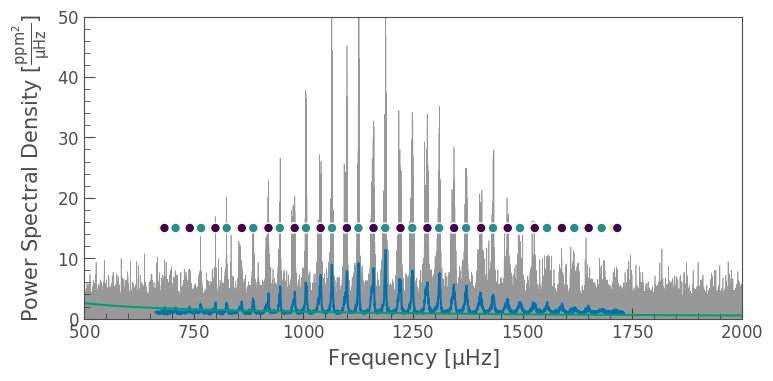

In [7]:
pg = lk.Periodogram(ff*u.microhertz, pp*(cds.ppm**2 / u.microhertz))
ax = pg.plot(alpha=.5)
ax.plot(f, p)
ax.plot(ff, mm)
plt.scatter(modelocs, [15]*len(modelocs),c=modeids, s=50, edgecolor='w',zorder=100)
ax.set_xlim(500,2000)
ax.set_ylim(0, 50)

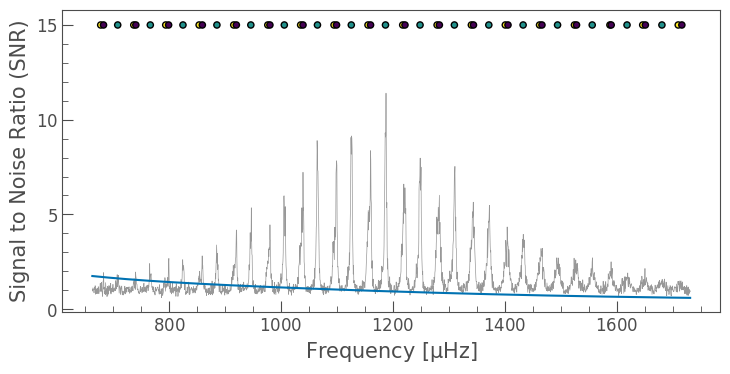

In [8]:
pg = lk.periodogram.SNRPeriodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5)
# pg.smooth(filter_width=3.).plot(ax=ax, linewidth=2)
ax.plot(f, m)
plt.scatter(modelocs, [15]*len(modelocs),c=modeids, s=20, edgecolor='k')
plt.show()

## Finding the mode frequencies through the asymptotic relation

We have good constraints on the mode frequencies from previous studies, but since we are using the same data, we don't want to use their posteriors as priors on our frequencies. Instead we want to find a way to include the prior knowledge from previous studies without making our study dependent on them.

The locations of the radial $l = 0$ modes can be predicted from the asymptotic relation. Radial modes of consecutive overtones are separated by the large frequency separation $\Delta\nu$, in principle. However in practice, these mode frequencies can be subject to some curvature, as well as noise from glitches in the sound speed profile in the stellar interior.

We're going to omit a detailed treatment of glitches for now, but we *will* include a curvature term, using the astymptotic relation presented in [Vrard et al. 2015](https://ui.adsabs.harvard.edu/abs/2015A%26A...579A..84V/abstract), which goes as

$\large\nu_{l=0} = (\bar{n} + \epsilon + (\frac{\alpha}{2}(n_{\rm max} - \bar{n})^2)) \Delta\nu + \Delta$

where $\nu_{\rm l=0}$ is the frequency locations of all l=0 modes at overtones $\bar{n}$, $\epsilon$ is the phase offset, $\alpha$ determines the curvature, $\Delta\nu$ is the large separation, and $n_{\rm max}$ is the overtone closest to $\nu_{\rm max}$, round which the curvature is centered, and is given by

$n_{\rm max} = \frac{\nu_{\rm max}}{\Delta\nu} - \epsilon$,

and $\Delta$ is the noise on the frequency positions. Including this noise term allows us to formalize the 'smoothness condition' ([Davies et al. 2016](https://ui.adsabs.harvard.edu/abs/2016MNRAS.456.2183D/abstract)), where we specify that the difference in large frequency separation between subsequent radial modes should be close to zero, with some scatter. We therefore specify $\Delta$ as:

$\Delta = \mathcal{N}(0, \sigma_\Delta)$,

where $\sigma_\Delta$ is a free parameter. I guess eventually we should really upgrade this to a Gaussian Process periodic Kernel, so that we take care of glitch patterns.

The positions of the dipole and octopole $l = 1, 2$ modes are then determined from the radial frequencies, as

$\nu_{l=1} = \nu_{l=0} + \delta\nu_{01} + \mathcal{N}(0, \sigma_{01})$

$\nu_{l=2} = \nu_{l=0} -  \delta\nu_{02} + \mathcal{N}(0, \sigma_{02})$

where $\delta\nu_{01}$ and $\delta\nu_{02}$ are the small separations between the radial frequency and the dipole and octopole frequencies of the same radial degree. $\sigma_{01}$ and $\sigma_{02}$ are the uncertainties on these separations. All are free parameters, and as before we're adding on noise.

So we know have a complex hierarchical system where the mode frequencies are latent parameters, and we have a bunch of hyperparameters controlling them, giving them noise and curvature. These hyperparameters are where we include our *prior* information from the Kages and LEGACY papers, as first guesses and as means on the distributions from which they are drawn.

$\epsilon \sim \mathcal{N}(\epsilon_{\rm prior}, 1.)$

$\alpha \sim \mathcal{N_{\rm log}}(\alpha_{\rm prior}, 1.)$

$\Delta\nu \sim \mathcal{N}(\Delta\nu_{\rm prior}, \Delta\nu_{\rm prior}*0.1)$

$\nu_{\rm max} \sim \mathcal{N}(\nu_{\rm max, \rm prior}, \nu_{\rm max, \rm prior}*0.1)$

$\delta\nu_{01} \sim \mathcal{N}(\delta\nu_{01, \rm prior}, \Delta\nu_{\rm prior}*0.1)$

$\delta\nu_{02} \sim \mathcal{N}(\delta\nu_{02, \rm prior}, 3.)$

$\epsilon$, $\alpha$ and the small separations will be determined from a fit to the mode frequencies of each star. The remainder are taken as reported in the literature.

The noise terms $\sigma_\Delta$, $\sigma_{01}$ and $\sigma_{02}$ will all be drawn from lognormal distributions, to ensure they don't go too close to zero.

Notice that I've flipped the sign in the equation for $\nu_{l=2}$. In a typical $l=0,2$ pair, the octopole mode is one overtone lower than the radial mode. When passing the overtone numbers into the model, we simply add $+1$ to those of the octopole modes to make this equation work and maintain our traditional measure of $\delta\nu_{\rm 02}$.

We use the overtone numbers $n$ reported in LEGACY and Kages, and also do not fit for any modes of oscillation not reported in those papers.

# Build the model

In [9]:
class model():
    def __init__(self, f, n0, n1, n2, f0_, f1_, f2_):
        self.f = f
        self.n0 = n0
        self.n1 = n1
        self.n2 = n2
        self.npts = len(f)
        self.M = [len(f0_), len(f1_), len(f2_)]
        
    def epsilon(self, i, l, m):
    #We use the prescriptions from Gizon & Solanki 2003 and Handberg & Campante 2012
        if l == 0:
            return 1
        if l == 1:
            if m == 0:
                return np.cos(i)**2
            if np.abs(m) == 1:
                return 0.5 * np.sin(i)**2
        if l == 2:
            if m == 0:
                return 0.25 * (3 * np.cos(i)**2 - 1)**2
            if np.abs(m) ==1:
                return (3/8)*np.sin(2*i)**2
            if np.abs(m) == 2:
                return (3/8) * np.sin(i)**4
        if l == 3:
            if m == 0:
                return (1/64)*(5*np.cos(3*i) + 3*np.cos(i))**2
            if np.abs(m) == 1:
                return (3/64)*(5*np.cos(2*i) + 3)**2 * np.sin(i)**2
            if np.abs(m) == 2:
                return (15/8) * np.cos(i)**2 * np.sin(i)**4
            if np.abs(m) == 3:
                return (5/16)*np.sin(i)**6
        
    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/w**2*(self.f - freq)**2)
    
    def mode(self, l, freqs, hs, ws, i, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * self.epsilon(i, l, m), 
                                     ws[idx])
  
    def model(self, p):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b = p
               
        # Calculate the modes
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, i)
        self.mode(1, f1, h1, g1, i, split)
        self.mode(2, f2, h2, g2, i, split)
               
        #Create the model
        self.mod = self.modes + b
        return self.mod

    def asymptotic(self, n, numax, deltanu, alpha, epsilon):       
        nmax = (numax / deltanu) - epsilon
        over = (n + epsilon + ((alpha/2)*(nmax - n)**2))
        return over * deltanu
    
    def f0(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n0, numax, deltanu, alpha, epsilon)
    
    def f1(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        f0 = self.asymptotic(self.n1, numax, deltanu, alpha, epsilon)
        return f0 + d01
    
    def f2(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        f0 = self.asymptotic(self.n2+1, numax, deltanu, alpha, epsilon)
        return f0 - d02

In [10]:
f0_ = modelocs[modeids==0]
f1_ = modelocs[modeids==1]
f2_ = modelocs[modeids==2]
f0_e = elocs[modeids==0]
f1_e = elocs[modeids==1]
f2_e = elocs[modeids==2]
n0 = overtones[modeids==0]
n1 = overtones[modeids==1]
n2 = overtones[modeids==2]

alpha_ = cad.alpha.values[0]
alpha_e = cad.e_alpha.values[0]
epsilon_ = cad.epsilon.values[0]
epsilon_e = cad.e_epsilon.values[0]
d01_ = cad.d01.values[0]
d01_e = cad.e_d01.values[0]
d02_ = cad.d02.values[0]
d02_e = cad.e_d02.values[0]
numax_ = star.numax
numax_e = star.enumax
deltanu_ = star.dnu
deltanu_e = star.ednu

Do some first guesses for height

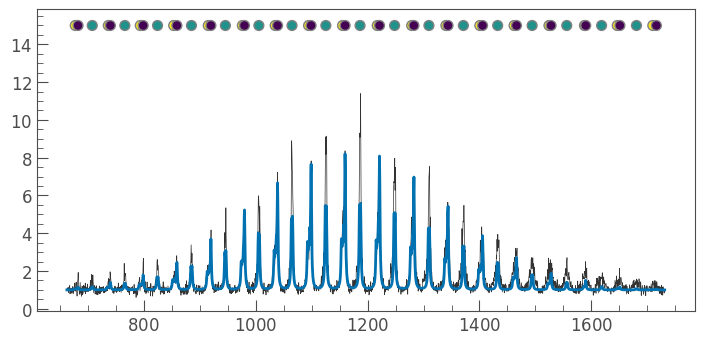

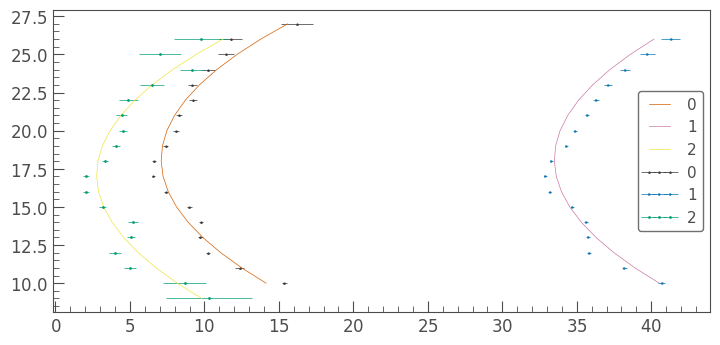

In [11]:
init_m =[f0_,                         # l0 modes
       f1_,                         # l1 modes
       f2_,                         # l2 modes
       np.ones(len(f0_)) * 2.0,     # l0 widths
       np.ones(len(f1_)) * 2.0,     # l1 widths
       np.ones(len(f2_)) * 2.0,     # l2 widths
       np.sqrt(gaussian(f0_, 0, numax_, 15.) * 2.0 * np.pi / 2.0) ,# l0 heights
       np.sqrt(gaussian(f1_, 1, numax_, 15.) * 2.0 * np.pi / 2.0) ,# l1 heights
       np.sqrt(gaussian(f2_, 2, numax_, 15.) * 2.0 * np.pi / 2.0) ,# l2 heights
       1.0 * np.sin(np.pi/2),       # projected splitting
       np.pi/2.,                    # inclination angle
       1.                           # background parameters
        ]

init_f =[numax_,                       # numax
       dnu_,                         # deltanu
       alpha_,                      # curvature term
       epsilon_,                    # phase term
       d01_ ,                       # small separation l=0,1
       d02_                        # small separation l=0,2
        ]

mod = model(f, n0, n1, n2, f0_, f1_, f2_)
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    ax.plot(f, p)
    ax.plot(f, mod.model(init_m), lw=2)
    ax.scatter(modelocs, [15]*len(modelocs),c=modeids, s=50, edgecolor='grey', zorder=100)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.errorbar(f0_%dnu_, n0, xerr=f0_e, fmt='^',label='0')
    ax.errorbar(f1_%dnu_, n1, xerr=f1_e, fmt='>',label='1')
    ax.errorbar(f2_%dnu_, n2, xerr=f2_e, fmt='o',label='2')

    ax.plot(mod.f0(init_f)%dnu_, n0, label='0')
    ax.plot(mod.f1(init_f)%dnu_, n1, label='1')
    ax.plot(mod.f2(init_f)%dnu_, n2, label='2')
    
    ax.legend()
    plt.show()

# Build the priors in PyMC3

In [12]:
pm_model = pm.Model()

with pm_model:
    # Frequency Hyperparameters
    alpha   = pm.TruncatedNormal('alpha',   mu=alpha_,   sigma=alpha_e,   testval=alpha_, lower=0.)
    epsilon = pm.TruncatedNormal('epsilon', mu=epsilon_, sigma=epsilon_e, testval=epsilon_, lower=0.)
    d01     = pm.TruncatedNormal('d01',     mu=d01_,     sigma=d01_e,     testval=d01_, lower=0.)
    d02     = pm.TruncatedNormal('d02',     mu=d02_,     sigma=d02_e,     testval=d02_, lower=0.)    
    numax   = pm.TruncatedNormal('numax',   mu=numax_,   sigma=numax_e,   testval=numax_, lower=0.)
    deltanu = pm.TruncatedNormal('deltanu', mu=deltanu_, sigma=deltanu_e, testval=deltanu_, lower=0.)

    # Noise hyperparameters and latent parameters
    sigma0 =  pm.Gamma('sigma0', alpha=2.0, beta=0.5, testval=2.)
    sigma01 = pm.Gamma('sigma01', alpha=2.0, beta=0.5, testval=2.)
    sigma02 = pm.Gamma('sigma02', alpha=2.0, beta=0.5, testval=2.)
    
    Delta0 = pm.Normal('Delta0', mu=0., sigma=1., shape=len(init_m[0]))
    Delta1 = pm.Normal('Delta1', mu=0., sigma=1., shape=len(init_m[1]))
    Delta2 = pm.Normal('Delta2', mu=0., sigma=1., shape=len(init_m[2]))
    
    #Frequencies
    f0 = pm.Deterministic('f0', mod.f0([numax_, deltanu_, alpha_, epsilon_, d01_, d02_]) + Delta0*sigma0)
    f1 = pm.Deterministic('f1', mod.f1([numax_, deltanu_, alpha_, epsilon_, d01_, d02_]) + Delta1*sigma01)
    f2 = pm.Deterministic('f2', mod.f2([numax_, deltanu_, alpha_, epsilon_, d01_, d02_]) + Delta2*sigma02)
    
    # Mode linewidths
    g0 = pm.HalfNormal('g0', sigma=2.0, testval=init_m[3], shape=len(init_m[3]))
    g1 = pm.HalfNormal('g1', sigma=2.0, testval=init_m[4], shape=len(init_m[4]))
    g2 = pm.HalfNormal('g2', sigma=2.0, testval=init_m[5], shape=len(init_m[5]))
    
    # Mode amplitudes
    a0 = pm.HalfNormal('a0', sigma=20., testval=init_m[6], shape=len(init_m[6]))
    a1 = pm.HalfNormal('a1', sigma=20., testval=init_m[7], shape=len(init_m[7]))
    a2 = pm.HalfNormal('a2', sigma=20., testval=init_m[8], shape=len(init_m[8]))
    
    # Mode heights (determined by amplitude and linewidth)
    h0 = pm.Deterministic('h0', 2*a0**2/np.pi/g0)
    h1 = pm.Deterministic('h1', 2*a1**2/np.pi/g1)
    h2 = pm.Deterministic('h2', 2*a2**2/np.pi/g2)
    
    # Rotation and inclination parameterizations
    xsplit = pm.HalfNormal('xsplit', sigma=2.0, testval=init_m[10])
    cosi = pm.Uniform('cosi', 0., 1.)
    
    # Detangled inclination and splitting
    i = pm.Deterministic('i', np.arccos(cosi))
    split = pm.Deterministic('split', xsplit/pm.math.sin(i))
    
    # Background terms
    b = pm.TruncatedNormal('b', mu=1., sigma=.1, testval=1., lower=0.)
    
    #Model
    fit = mod.model([f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b])
    
#     like = pm.Gamma('like', alpha=1, beta=1.0/fit, observed=p)
    like = pm.Normal('like', mu=fit, sigma=2, observed=p)

In [ ]:
init = 1000
with pm_model:
    trace = pm.sample(chains=4, tune=int(init/2), draws=int(init/2))

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...


In [ ]:
pm.traceplot(trace, var_names=['alpha','epsilon','numax','deltanu','d01','d02',
                             'f0','f1','f2','Delta0','Delta01','Delta02','sigma0', 'sigma01', 'sigma02',
                            'h0','h1','h2','g0','g1','g2','a0','a1','a2','xsplit','cosi','i','split','b'])
plt.show()

In [ ]:
pm.summary(trace, var_names=['alpha','epsilon','numax','deltanu','d01','d02',
                             'f0','f1','f2','Delta0','Delta01','Delta02','sigma0', 'sigma01', 'sigma02',
                            'h0','h1','h2','g0','g1','g2','a0','a1','a2','xsplit','cosi','i','split','b'])

# Now lets plot some diagnostics...

In [ ]:
labels=['xsplit','cosi','i','split','b','numax','deltanu','alpha','epsilon','d01','d02']
chain = np.array([trace[label] for label in labels])
verbose = [r'$\delta\nu_s^*$',r'$\cos(i)$',r'$i$',r'$\delta\nu_{\rm s}$',
          r'$\nu_{\rm max}$', r'$\Delta\nu$', r'$\alpha$',r'$\epsilon$',r'$\delta\nu_{01}$',r'$\delta\nu_{02}$']
corner.corner(chain.T, labels=verbose, quantiles=[0.16, 0.5, 0.84]
              ,show_titles=True)
plt.show()

In [ ]:
for idx in range(len(trace['h0'].T)):
    chain = np.array([trace['a0'].T[idx], trace['h0'].T[idx], trace['g0'].T[idx], trace['f0'].T[idx]])
    corner.corner(chain.T, labels=['A','H','g','f'],
                  quantiles=[0.16, 0.5, 0.84],show_titles=True)
    plt.show()

Looks like all the background parameters have been tightened up or remained within the priors. Always good to check!

### Now let's plot some output evaluation:

In [ ]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    ax.plot(f, p)
    labels=['f0','f1','f2','g0','g1','g2','h0','h1','h2','split','i', 'phi']
    res = np.array([np.median(trace[label],axis=0) for label in labels])    
    ax.plot(f, mod.model(init_m), lw=2)
    plt.show()
    
    fig, ax = plt.subplots()
    
    res = [np.median(trace[label]) for label in ['numax','deltanu','alpha','epsilon','d01','d02']]
    resls = [np.median(trace[label],axis=0) for label in['f0','f1','f2']]
    stdls = [np.std(trace[label],axis=0) for label in['f0','f1','f2']]
    
    ax.plot(mod.f0(res)%res[1], n0, label='0 asy')
    ax.plot(mod.f1(res)%res[1], n1, label='1 asy')
    ax.plot(mod.f2(res)%res[1], n2, label='2 asy')
    
    ax.errorbar(resls[0]%res[1], n0, xerr=stdls[0], fmt='^',label='0 mod')
    ax.errorbar(resls[1]%res[1], n1, xerr=stdls[1], fmt='>',label='1 mod')
    ax.errorbar(resls[2]%res[1], n2, xerr=stdls[2], fmt='o',label='2 mod')
    
    ax.legend()

In [ ]:
labels=['f0','f1','f2','g0','g1','g2','h0','h1','h2','split','i', 'phi']
res = np.array([np.median(trace[label],axis=0) for label in labels])  
residual = p/mod.model(res)
sns.distplot(residual, label='Model')
sns.distplot(np.random.chisquare(2, size=10000)/2, label=r'Chi22')
sns.distplot(np.random.normal(size=10000)*np.std(residual) + np.mean(residual), label='Gaussian')
plt.legend()

The model doesn't fit the $\chi_2^2$ noise, probably because its binned? 

# Verdict:

I'm confident in the completion of this addition, but it takes too long a time to use when testing other targets. I'll save it for now, run a longer test overnight and move on to GP testing.

In [ ]:
import sys
sys.exit()

# Leftovers

In [ ]:
res = [np.median(trace[label]) for label in ['numax','deltanu','alpha','epsilon','d01','d02']]

resls = [np.median(trace[label],axis=0) for label in['f0','f1','f2']]
stdls = [np.std(trace[label],axis=0) for label in['f0','f1','f2']]


with plt.style.context(ms.ms):
    fig, ax = plt.subplots()
    
    ax.plot(mod.f0(res)%res[1], n0, label='0 asy')
    ax.plot(mod.f1(res)%res[1], n1, label='1 asy')
    ax.plot(mod.f2(res)%res[1], n2, label='2 asy')
    
    ax.errorbar(resls[0]%res[1], n0, xerr=stdls[0], fmt='^',label='0 mod')
    ax.errorbar(resls[1]%res[1], n1, xerr=stdls[1], fmt='>',label='1 mod')
    ax.errorbar(resls[2]%res[1], n2, xerr=stdls[2], fmt='o',label='2 mod')
    
    ax.errorbar(f0_%res[1], n0, xerr=f0_e, fmt='^',label='0 lit')
    ax.errorbar(f1_%res[1], n1, xerr=f1_e, fmt='>',label='1 lit')
    ax.errorbar(f2_%res[1], n2, xerr=f2_e, fmt='o',label='2 lit')    
    
    ax.legend()